In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from lxml import etree
import numpy as np
import glob
from matplotlib.patches import Rectangle

In [2]:
img = tf.io.read_file('./mc/images/Abyssinian_1.jpg')

In [3]:
#解码图片
img = tf.image.decode_jpeg(img)

In [4]:
img.shape

TensorShape([400, 600, 3])

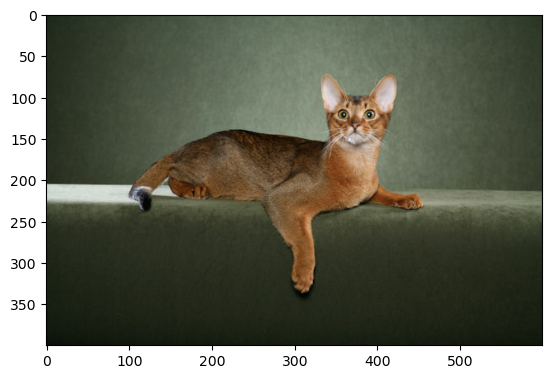

In [5]:
plt.imshow(img)

In [6]:
xml = open('./mc/annotations/xmls/Abyssinian_1.xml').read()

In [7]:
#建立选择器
sel = etree.HTML(xml)

In [8]:
width = int(sel.xpath('//size/width/text()')[0])
width

600

In [9]:
height = int(sel.xpath('//size/height/text()')[0])
xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
ymax = int(sel.xpath('//bndbox/ymax/text()')[0])

In [10]:
width, height, xmin, xmax, ymin, ymax

(600, 400, 333, 425, 72, 158)

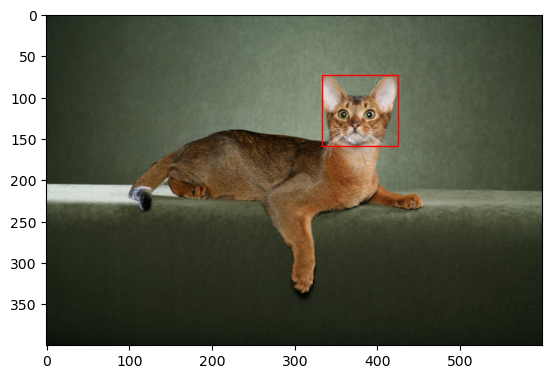

In [11]:
plt.imshow(img)
rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='red') #图片左下角的坐标值，宽度，高度，不填充，红色
ax = plt.gca()#获取当前图像
ax.axes.add_patch(rect)

In [12]:
#13.3

In [13]:
#图像缩放

In [14]:
img = tf.image.resize(img, [224,224])

In [15]:
#标准化 
img = img/255

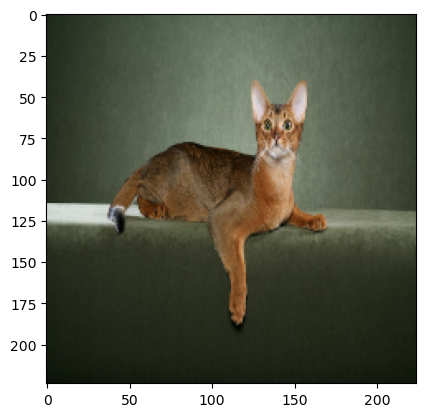

In [16]:
plt.imshow(img)

In [17]:
xmin = (xmin/width)*224
ymin = (ymin/height)*224
xmax = (xmax/width)*224
ymax = (ymax/height)*224

In [18]:
#创建输入管道

In [19]:
images = glob.glob('./mc/images/*.jpg')

In [20]:
images[:5]

['./mc/images\\Abyssinian_1.jpg',
 './mc/images\\Abyssinian_10.jpg',
 './mc/images\\Abyssinian_100.jpg',
 './mc/images\\Abyssinian_101.jpg',
 './mc/images\\Abyssinian_102.jpg']

In [21]:
len(images)

7390

In [22]:
xmls = glob.glob('./mc/annotations/xmls/*.xml')

In [23]:
xmls[:3]

['./mc/annotations/xmls\\Abyssinian_1.xml',
 './mc/annotations/xmls\\Abyssinian_10.xml',
 './mc/annotations/xmls\\Abyssinian_100.xml']

In [24]:
len(xmls) #这里并不是所有图片都有xml

3686

In [25]:
names = [x.split('\\')[-1].split('.xml')[0] for x in xmls]

In [26]:
names[:3]

['Abyssinian_1', 'Abyssinian_10', 'Abyssinian_100']

In [27]:
imgs_train = [img for img in images if (img.split('\\')[-1].split('.jpg')[0] in names)]
# 取出所有有xml的图片

In [28]:
len(imgs_train)

3686

In [29]:
imgs_test = [img for img in images if (img.split('\\')[-1].split('.jpg')[0] not in names)]
# 取出所有没有xml的图片

In [30]:
imgs_train.sort(key=lambda x:x.split('\\')[-1].split('.jpg')[0])
#对图片进行排序，使其与xml一一对应

In [31]:
xmls.sort(key=lambda x:x.split('\\')[-1].split('.xml')[0])
#对xml进行排序，使其与图片一一对应

In [32]:
imgs_train[-5:]

['./mc/images\\yorkshire_terrier_186.jpg',
 './mc/images\\yorkshire_terrier_187.jpg',
 './mc/images\\yorkshire_terrier_188.jpg',
 './mc/images\\yorkshire_terrier_189.jpg',
 './mc/images\\yorkshire_terrier_190.jpg']

In [33]:
xmls[-5:]

['./mc/annotations/xmls\\yorkshire_terrier_186.xml',
 './mc/annotations/xmls\\yorkshire_terrier_187.xml',
 './mc/annotations/xmls\\yorkshire_terrier_188.xml',
 './mc/annotations/xmls\\yorkshire_terrier_189.xml',
 './mc/annotations/xmls\\yorkshire_terrier_190.xml']

In [34]:
#13.5

In [35]:
def to_labels(path):
    xml = open('{}'.format(path)).read()
    sel = etree.HTML(xml)
    width = int(sel.xpath('//size/width/text()')[0])
    height = int(sel.xpath('//size/height/text()')[0])
    xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
    xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
    ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
    ymax = int(sel.xpath('//bndbox/ymax/text()')[0])
    return [xmin/width, ymin/height, xmax/width, ymax/height]

In [36]:
labels = [to_labels(path) for path in xmls]

In [37]:
labels[:3]

[[0.555, 0.18, 0.7083333333333334, 0.395],
 [0.192, 0.21, 0.768, 0.582],
 [0.383248730964467, 0.142, 0.850253807106599, 0.534]]

In [38]:
out1, out2, out3, out4 = list(zip(*labels)) #zip(* ) 是zip的反操作

In [39]:
len(out1),len(out2),len(out3),len(out4)

(3686, 3686, 3686, 3686)

In [40]:
out1 = np.array(out1)
out2 = np.array(out2)
out3 = np.array(out3)
out4 = np.array(out4)

In [41]:
label_datasets = tf.data.Dataset.from_tensor_slices((out1, out2, out3, out4))

In [42]:
label_datasets

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.float64, tf.float64, tf.float64, tf.float64)>

In [43]:
#图片数据

In [44]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)#图片解码
    img = tf.image.resize(img, [224, 224])
    img = img/127.5 - 1 #像素的范围是0到255，除255是0到1 乘2是0到2 减1是-1到1
    return img

In [45]:
image_dataset = tf.data.Dataset.from_tensor_slices(imgs_train)

In [46]:
image_dataset = image_dataset.map(load_image)

In [47]:
image_dataset

<MapDataset shapes: (224, 224, 3), types: tf.float32>

In [48]:
dataset = tf.data.Dataset.zip((image_dataset, label_datasets))

In [49]:
#自己练习：将数据集分成训练数据与测试数据

In [50]:
test_count = int(len(images)*0.2)#大约选取20%的数据作为测试数据
train_count = len(images) - test_count

#跳过测试数据的个数，得到训练数据
train_dataset = dataset.skip(test_count)
#取测试数据的个数
test_dataset = dataset.take(test_count) 

In [51]:
train_dataset

<SkipDataset shapes: ((224, 224, 3), ((), (), (), ())), types: (tf.float32, (tf.float64, tf.float64, tf.float64, tf.float64))>

In [52]:
train_dataset = train_dataset.repeat().shuffle(len(imgs_train)).batch(32)

In [53]:
test_dataset = test_dataset.repeat().batch(32)

In [54]:
#验证是否正确

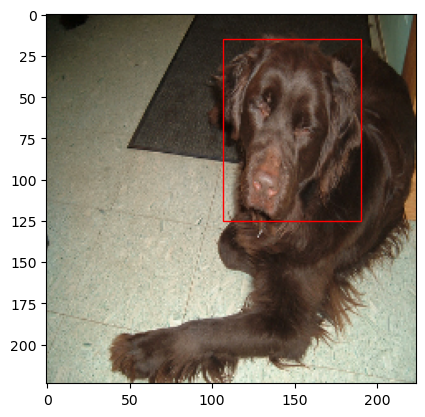

In [55]:
for img,label in train_dataset.take(1):
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    out1,out2,out3,out4 = label
    xmin,ymin,xmax,ymax = out1[0].numpy()*224,out2[0].numpy()*224,out3[0].numpy()*224,out4[0].numpy()*224
    rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='red') #图片左下角的坐标值，宽度，高度，不填充，红色
    ax = plt.gca()#获取当前图像
    ax.axes.add_patch(rect)
    plt.show()

In [56]:
#创建图像定位的模型

In [57]:
xception = tf.keras.applications.Xception(weights='imagenet',
                                         include_top=False,
                                         input_shape=(224,224,3))

In [58]:
inputs = tf.keras.layers.Input(shape=(224,224,3))

x = xception(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)

out1 = tf.keras.layers.Dense(1)(x)
out2 = tf.keras.layers.Dense(1)(x)
out3 = tf.keras.layers.Dense(1)(x)
out4 = tf.keras.layers.Dense(1)(x)

prediction = [out1, out2, out3, out4]

model = tf.keras.models.Model(inputs=inputs, outputs=prediction)

In [59]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mse',
              metrics=['mae']) #平均绝对误差

In [60]:
EPOCHS = 50
VALIDATION_STEPS = test_count//32
STEPS_PER_EPOCH = train_count//32

In [61]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=test_dataset)

Train for 184 steps, validate for 46 steps
Epoch 1/50
  2/184 [..............................] - ETA: 1:11:30 - loss: 1.2963 - dense_2_loss: 0.0478 - dense_3_loss: 0.1201 - dense_4_loss: 0.5669 - dense_5_loss: 0.5616 - dense_2_mae: 0.1874 - dense_3_mae: 0.2822 - dense_4_mae: 0.7376 - dense_5_mae: 0.7270

KeyboardInterrupt: 

In [ ]:
#13.8

In [ ]:
model.save('detect_v1.h5')

In [63]:
new_model = tf.keras.models.load_model('detect_v1.h5')

ValueError: Unknown layer: Functional